## Photometry With MCMC

Having gotten the target files in the previous notebook, I'm going to now use the file `corecomposition/photometry.py` to fetch more photometry from either DES or PANSTARRS. Then, I'll run MCMC with a much better constraint on the temperature which will also give me a better constraint on the radius. 

First, I'll read in the gold, silver, and bronze samples. The gold and silver samples are both subsets of the bronze sample, so I'll do all of the analysis on the bronze table (since that will also analyze the stars in the gold and silver samples). 

In [1]:
### general
import numpy as np
import pickle
import matplotlib.pyplot as plt
plt.style.use('stefan.mplstyle')

### astropy
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, join

### project-specific
import sys
sys.path.append('../')
sys.path.append('../../')
import corecomposition as cc
import WD_models

gold = Table.read('../data/processed/gold.csv')
silver = Table.read('../data/processed/silver.csv')
bronze = Table.read('../data/processed/bronze.csv')

In [10]:
# Access astronomical databases
# Sky visualization
from ipyaladin import Aladin    # version >=0.3.
# For plots
import matplotlib.pyplot as plt




IndexError: index 0 is out of bounds for axis 0 with size 0

In [12]:
# execute a synchronous ADQL query
tap_service = voresource.get_service("tap")



In [14]:
tap_records.to_table()

RAJ2000,DEJ2000,objID,cell,sky,f_objID,Qual,e_RAJ2000,e_DEJ2000,Epoch,Ns,Nd,Ng,Nr,Ni,Nz,Ny,gPSFf,gmag,e_gmag,gmagStd,o_gmag,b_gmag,B_gmag,gKmag,e_gKmag,gFlags,rPSFf,rmag,e_rmag,rmagStd,o_rmag,b_rmag,B_rmag,rKmag,e_rKmag,rFlags,iPSFf,imag,e_imag,imagStd,o_imag,b_imag,B_imag,iKmag,e_iKmag,iFlags,zPSFf,zmag,e_zmag,zmagStd,o_zmag,b_zmag,B_zmag,zKmag,e_zKmag,zFlags,yPSFf,ymag,e_ymag,ymagStd,o_ymag,b_ymag,B_ymag,yKmag,e_yKmag,yFlags
deg,deg,,,,,,arcsec,arcsec,d,,,,,,,,,mag,mag,mag,,mag,mag,mag,mag,,,mag,mag,mag,,mag,mag,mag,mag,,,mag,mag,mag,,mag,mag,mag,mag,,,mag,mag,mag,,mag,mag,mag,mag,,,mag,mag,mag,,mag,mag,mag,mag,
float64,float64,int64,int16,int16,int64,int16,float64,float64,float64,int16,int16,int16,int16,int16,int16,int16,float64,float64,float32,float32,int16,float32,float32,float32,float32,int32,float64,float32,float32,float32,int16,float32,float32,float32,float32,int32,float64,float32,float32,float32,int16,float32,float32,float32,float32,int32,float64,float32,float32,float32,int16,float32,float32,float32,float32,int32,float64,float32,float32,float32,int16,float32,float32,float32,float32,int32
45.328156,1.6192442,109940453281163572,1333,41,503635968,60,0.0054,0.012,56339.4906713,5,84,11,14,29,16,14,0.999191,21.3148,0.0278,0.087,7,21.1574,21.3878,21.4581,0.0609,115000,0.999665,20.0479,0.0148,0.055,14,19.9733,20.1487,20.0962,0.027,115000,0.999669,18.7052,0.005,0.0299,24,18.6299,18.7792,18.8012,0.0061,115000,0.99937,18.0743,0.0084,0.0318,12,17.9946,18.1287,18.1702,0.013,115000,0.999364,17.7768,0.01,0.0449,13,17.7499,17.8809,17.8684,0.0318,115000
45.3262474,1.61930669,109940453262143638,1333,41,436527104,52,0.004,0.0191,56391.05233796,5,75,6,12,27,15,15,0.999483,21.5985,0.0416,0.1483,5,21.4245,21.8255,21.6726,0.1063,115000,0.999678,20.5265,0.0211,0.0738,11,20.4125,20.6318,20.6581,0.0327,115000,0.99953,19.3208,0.0055,0.0387,24,19.2676,19.4534,19.4375,0.0112,115000,0.999268,18.7872,0.0138,0.0459,15,18.7312,18.8857,18.9018,0.0145,115000,0.999551,18.529,0.0139,0.1038,14,18.4215,18.7216,18.6788,0.0522,115000
45.3526073,1.61176941,109930453525684636,1333,41,436527104,52,0.0299,0.0388,56281.11703704,8,22,0,3,15,4,0,--,--,--,--,0,--,--,--,--,16416,0.998509,21.7503,0.2109,0.2989,2,21.5528,21.9747,21.3608,0.2331,16892216,0.998683,21.2326,0.0375,0.1341,13,21.0083,21.3807,21.1986,0.0537,115000,0.998415,20.8547,0.1005,0.1926,4,20.6833,21.1297,20.7758,0.0398,115000,--,--,--,--,0,--,--,--,--,114720
45.34967784,1.62116092,109940453497995864,1333,41,302145536,36,0.0586,0.0586,56903.70090278,0,4,0,0,3,0,1,--,--,--,--,0,--,--,--,--,0,--,--,--,--,0,--,--,--,--,0,0.998399,20.3823,0.0286,0.0708,3,20.2908,20.4179,20.3473,0.1358,272,--,--,--,--,0,--,--,--,--,0,0.999116,19.4248,0.1812,--,1,19.4248,19.4248,--,--,280
45.34966408,1.62117553,109940453494925916,1333,41,444915712,53,0.0153,0.0165,56296.97109954,5,53,0,14,20,12,7,--,--,--,--,0,--,--,--,--,114720,0.999299,21.0801,0.0179,0.0626,12,20.9855,21.1958,20.8231,0.0431,16892216,0.998818,20.4246,0.0158,0.0983,19,20.3011,20.7034,20.1872,0.0406,16892216,0.999636,20.0806,0.0447,0.1696,11,19.962,20.4058,19.9107,0.0629,115000,0.9992,19.8254,0.1461,0.2218,6,19.5236,20.1658,19.7475,0.1925,115000
45.36389216,1.61635561,109930453641089954,1333,41,302067712,36,0.0177,0.0177,56623.48440972,0,3,0,3,0,0,0,--,--,--,--,0,--,--,--,--,0,0.884287,17.9894,0.0094,--,1,17.9894,17.9894,--,--,280,--,--,--,--,0,--,--,--,--,0,--,--,--,--,0,--,--,--,--,0,--,--,--,--,0,--,--,--,--,0
45.36628923,1.62068386,109940453662535344,1333,41,436527232,52,0.0232,0.023,56454.35896991,5,44,1,13,17,8,5,0.998348,22.2243,0.1696,--,1,22.2243,22.2243,22.2849,0.2878,115000,0.999537,21.4826,0.0424,0.2034,12,21.0374,21.7023,21.3708,0.0775,115000,0.999115,20.9125,0.0264,0.1141,12,20.6108,21.0391,20.8279,0.0696,115000,0.998632,20.6119,0.0651,0.2352,7,20.2462,20.983,20.4901,0.0842,115000,0.998918,20.2201,0.0871,0.156,4,20.1624,20.4749,19.9809,0.1311,115000
45.35365913,1.62183032,109940453536456643,1333,41,436527104,52,0.0108,0.0312,56280.47256944,5,80,1

The function `corecomposition/photometry.py:fetch_photometry()` uses `TAP` to query DES and PANSTARRS for extra photometry. I use DES's published conversion functions to turn their photometry into PANSTARRS bands, and prefer that over actual PANSTARRS photometry wherever possible. 

In [2]:
photo = cc.photometry.fetch_photometry(bronze['wd_source_id']) # fetch PANSTARRS and DES photometry for the source_ids in the sample
bronze = join(bronze, photo, keys_left='wd_source_id', keys_right='source_id') # join the two on the wd source_id

The photometry is processed in several steps:
1. The Gaia photometry is collected, and the G-band magnitude is corrected using Tyler's code.
2. Extra photometry is collected by querying DES and PANSTARRS, and that is added to the list of photometry.
3. The photometry is dereddened using the Edenhofer+2023 dustmap.
4. Tyler's code is used to fit teff and radius using the available bands with MCMC.

In the next two cells, I collect all the information that will be necessary to run the MCMC fit. I use the radius and teff fitted with least squares as the initial guess for MCMC to hopefully avoid false minima.

In [3]:
# information needed for MCMC fitting each target
source_ids = bronze['wd_source_id'] # array of source_ids
coords = [SkyCoord(frame="galactic", l=bronze['wd_l'][i]*u.deg, b=bronze['wd_b'][i]*u.deg, distance = bronze['r_med_geo'][i] * u.pc) for i in range(len(bronze))] # contains the locations of each target
astrometric_params = bronze['wd_astrometric_params_solved'] # used for correcting g-band in Tyler's code
photo = np.array([bronze['wd_phot_g_mean_mag'], bronze['wd_phot_bp_mean_mag'], bronze['wd_phot_rp_mean_mag']]).T # the basic Gaia photometry
e_photo = np.array([bronze['wd_e_gmag'], bronze['wd_e_bpmag'], bronze['wd_e_rpmag']]).T # Gaia photometry error
initial_params = np.array([[10000]*len(bronze), bronze['cmd_radius']]).T # initial guesses

Now, I can pass this information to the class `corecomposition/photometry.py:Photometry()` which will automatically collect the DES/PANSTARRS photometry, apply the G-band correction, apply dereddening to each band, and get everything in order to perform the MCMC fit.

In [4]:
obj = cc.photometry.Photometry(source_ids, coords, astrometric_params, photo, e_photo, initial_params)

100%|██████████| 30/30 [00:00<00:00, 423.65it/s]


In [5]:
# array([20.69774628, 20.85405159, 20.11615562, 21.40539932, 20.65850067, 20.30249977, 20.21529961, 20.07729912])

In [6]:
obj.bands[0]

array(['Gaia_G', 'Gaia_BP', 'Gaia_RP', 'PS1_g', 'PS1_r', 'PS1_i', 'PS1_z',
       'PS1_y'], dtype='<U7')

Running this many MCMC fits takes a while, so I save the chains in a dictionary whose keys are the Gaia source ids. I've pre-computed the CO core compositions, which I load in in the next cell. Because it takes so long to run, I've set the cells to `raw` so that they won't run by default. 

In [7]:
import corner

def plot_corner(chain):
    labels = [r'$T_{eff}$ $[K]$', r'Radius $[R_\odot]$']
    best_est = np.zeros((len(labels)))
    unc = []

    for i in range(len(labels)):
        mcmc = np.percentile(chain[:, i],[16,50,84])
        best_est[i] = mcmc[1]
        unc.append(np.diff(mcmc))
    unc = np.array(unc)

    emcee_plot = corner.corner(chain, labels=labels, truths = best_est, quantiles = [0.16, 0.5, 0.84], show_titles = True, 
                            title_fmt = '.3f', title_kwargs={"fontsize": 12})
    plt.show()

In [8]:
with open('../data/cleaned/radius_chains_warwick_da.pkl', 'rb') as f:
    warwick_da_chains = pickle.load(f)

with open('../data/cleaned/radius_chains_CO_Hdef.pkl', 'rb') as f:
    co_hdef_chains = pickle.load(f)

with open('../data/cleaned/radius_chains_CO_Hrich.pkl', 'rb') as f:
    co_hrich_chains = pickle.load(f)

#with open('../data/cleaned/radius_chains_ONe_Hdef.pkl', 'rb') as f:
#    one_hdef_chains = pickle.load(f)

#with open('../data/cleaned/radius_chains_ONe_Hrich.pkl', 'rb') as f:
#    one_hrich_chains = pickle.load(f)

In [9]:
source_ids = obj.source_ids
radius_med = []
radius_low = []
radius_high = []

for wdid in source_ids:
    mcmc = np.percentile(warwick_da_chains[wdid][:,1],[16,50,84])
    unc = np.diff(mcmc)
    radius_med.append(mcmc[1])
    radius_low.append(unc[0])
    radius_high.append(unc[1])

radius_table = Table()
radius_table['wd_source_id'] = source_ids
radius_table['radius_med'] = radius_med
radius_table['radius_low'] = radius_low
radius_table['radius_high'] = radius_high

In [10]:
catalog = join(bronze, radius_table, keys='wd_source_id')
catalog['radius_sigma'] = (catalog['radius_med'] - catalog['cmd_radius'])
silver = np.isin(catalog['wd_source_id'], silver['wd_source_id'])
gold = np.isin(catalog['wd_source_id'], gold['wd_source_id'])

<>:4: SyntaxWarning: invalid escape sequence '\o'
<>:4: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_21153/3410762465.py:4: SyntaxWarning: invalid escape sequence '\o'
  ax1.set_ylabel('$R_{CMD}-R_{MCMC}$ [$R_\odot$]')


Text(0.5, 0, 'WD RUWE')

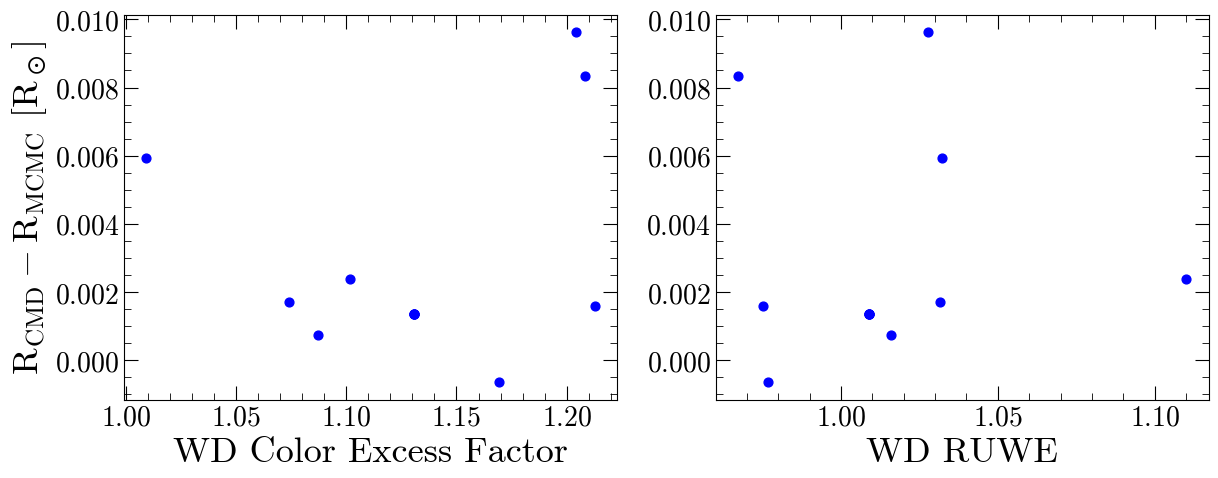

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,5))
ax1.scatter(catalog[silver]['wd_phot_bp_rp_excess_factor'], catalog[silver]['radius_sigma'], s=40, c = 'blue')
ax1.set_xlabel('WD Color Excess Factor')
ax1.set_ylabel('$R_{CMD}-R_{MCMC}$ [$R_\odot$]')

ax2.scatter(catalog[silver]['wd_ruwe'], catalog[silver]['radius_sigma'], s=40, c = 'blue')
ax2.set_xlabel('WD RUWE')


In [12]:
import pyphot
filter_library = pyphot.get_library()

def make_ps1_cmd(catalog):
    g = catalog['PS1_g'].data
    r = catalog['PS1_r'].data
    lib = pyphot.get_library()
    filters = [lib['PS1_g'], lib['PS1_r'], lib['PS1_i'], lib['PS1_z'], lib['PS1_y']]
    vega_zeros = np.array([filt.Vega_zero_Jy.value for filt in filters])

    # converts to mag
    g_jy = vega_zeros[0] * 10**(g / -2.5)
    r_jy = vega_zeros[1] * 10**(r / -2.5)

    g_ab = - 2.5 * np.log10(g_jy * 1e-23) - 48.594
    r_ab = - 2.5 * np.log10(r_jy * 1e-23) - 48.594
    return (g_ab - r_ab).filled(-999), g_ab.filled(-999), r_ab.filled(-999), g_jy, r_jy

def logg_cmd_position(radarray, loggarray, lowmass = 'f', midmass = 'f', highmass = 'f', bands=('bp3-rp3', 'G3')):
    font_model = WD_models.load_model(lowmass, midmass, highmass, 'H', HR_bands = bands)
    rsun_logg_to_m = WD_models.interp_xy_z_func(x = font_model['color'], y = font_model['logg'],\
                                                z = font_model['Mag'], interp_type = 'linear')
    mass = rsun_logg_to_m(radarray, loggarray)
    return mass

colors = np.linspace(-0.5, 1, 100)
gaia_theoretical_rvs_7 = logg_cmd_position(colors, 7, 'f', 'f', 'f', bands=('bp3-rp3', 'G3'))
gaia_theoretical_rvs_7_5 = logg_cmd_position(colors, 7.5, 'f', 'f', 'f', bands=('bp3-rp3', 'G3'))
gaia_theoretical_rvs_8 = logg_cmd_position(colors, 8, 'f', 'f', 'f', bands=('bp3-rp3', 'G3'))
gaia_theoretical_rvs_9 = logg_cmd_position(colors, 9, 'f', 'f', 'f', bands=('bp3-rp3', 'G3'))

ps1_theoretical_rvs_7 = logg_cmd_position(colors, 7, 'f', 'f', 'f', bands=('Pg-Pr', 'Pr'))
ps1_theoretical_rvs_7_5 = logg_cmd_position(colors, 7.5, 'f', 'f', 'f', bands=('Pg-Pr', 'Pr'))
ps1_theoretical_rvs_8 = logg_cmd_position(colors, 8, 'f', 'f', 'f', bands=('Pg-Pr', 'Pr'))
ps1_theoretical_rvs_9 = logg_cmd_position(colors, 9, 'f', 'f', 'f', bands=('Pg-Pr', 'Pr'))

/home/arsen/miniconda3/envs/core-composition/lib/python3.12/site-packages/numpy/ma/core.py:6980: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


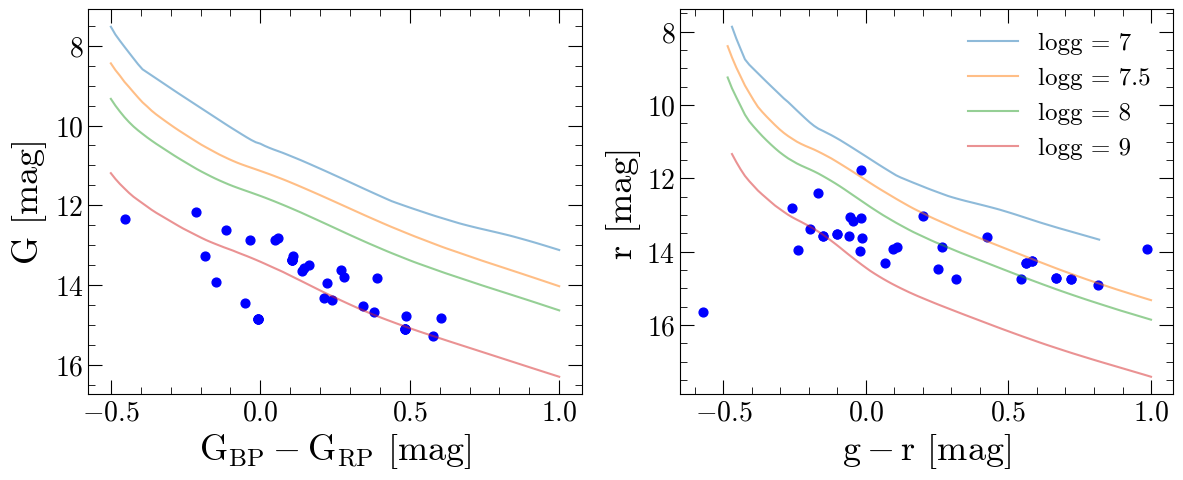

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,5))

a = 0.5
ax1.plot(colors, gaia_theoretical_rvs_7, alpha = a, label = 'logg = 7')
ax1.plot(colors, gaia_theoretical_rvs_7_5, alpha = a, label = 'logg = 7.5')
ax1.plot(colors, gaia_theoretical_rvs_8, alpha = a, label = 'logg = 8')
ax1.plot(colors, gaia_theoretical_rvs_9, alpha = a, label = 'logg = 9')

ax1.scatter(catalog['bpmag_dereddened'] - catalog['rpmag_dereddened'], catalog['wd_m_g'], s = 40, c = 'blue')
ax1.invert_yaxis()
ax1.set_xlabel('$G_{BP}-G_{RP}$ [mag]')
ax1.set_ylabel('$G$ [mag]')

ax2.plot(colors, ps1_theoretical_rvs_7, alpha = a, label = 'logg = 7')
ax2.plot(colors, ps1_theoretical_rvs_7_5, alpha = a, label = 'logg = 7.5')
ax2.plot(colors, ps1_theoretical_rvs_8, alpha = a, label = 'logg = 8')
ax2.plot(colors, ps1_theoretical_rvs_9, alpha = a, label = 'logg = 9')

g_r, g, r, g_jy, r_jy = make_ps1_cmd(catalog)

temp = np.all([catalog['PS1_r'] > -50, catalog['PS1_g'] > -50], axis = 0)
ax2.scatter(g_r[temp], r[temp] - 5 * (np.log10(catalog[temp]['r_med_geo']) - 1), s = 40, c = 'blue')
ax2.invert_yaxis()
ax2.set_xlabel('$g - r$ [mag]')
ax2.set_ylabel('r [mag]')
ax2.legend(framealpha=0)


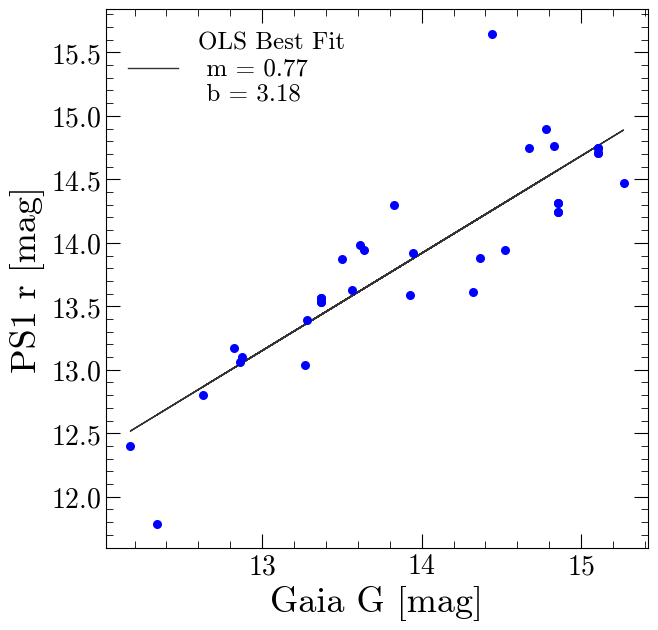

In [14]:
x = catalog[temp]['wd_m_g']
y = r[temp] - 5 * (np.log10(catalog[temp]['r_med_geo']) - 1)
m, b = np.polyfit(x, y, 1)

plt.scatter(x, y, s = 30, c = 'blue')
plt.plot(x, m*x+b, c = 'k', alpha = 0.8, zorder = 0, lw = 1, label = f'OLS Best Fit\n m = {m:2.2f}\n b = {b:2.2f}')
plt.xlabel('Gaia G [mag]')
plt.ylabel('PS1 r [mag]')
plt.legend(framealpha=0)

In [15]:
i = 0
catalog['wd_source_id'][i], g_jy[i], r_jy[i]

(1307515077152381568, 2.18595e-05, 2.7961441e-05)

In [16]:
catalog[['wd_source_id', 'wd_phot_g_mean_mag']]

wd_source_id,wd_phot_g_mean_mag
int64,float64
1307515077152381568,20.463973999023438
1424062412046712576,19.94845962524414
1505061200282617728,20.443767547607422
1699104219238181248,20.058536529541016
1792836069385045760,19.998979568481445
1889409474189137152,20.545780181884766
1895697134508504704,20.51539421081543
2153552814748001792,19.824588775634766
2577004017102144256,20.096324920654297


## Radius Debugging

In [17]:
i = 0
wd_id = catalog[gold]['wd_source_id'][i]

j = np.where(obj.source_ids == wd_id)[0][0]

In [18]:
source_ids = obj.source_ids[j]
distance = obj.geometry[j].distance.value
bands = obj.bands[j]
photomet = obj.photometry[j]
e_photomet = obj.e_photometry[j]
initial_guess = obj.initial_guess[j]

base_wavl, model_spec, model_spec_low_logg, table = cc.interpolator.utils.build_warwick_da()
build_spec = lambda best_est, distance : 4*np.pi*model_spec((best_est[0], 9)) * ((best_est[1] * 6.957e8) / (distance * 3.086775e16))**2

In [19]:
photomet

array([19.82458878, 19.92307281, 19.77752686, 19.96059799, 19.73803711,
       19.58703995, 19.54175377, 19.57049751])

['Gaia_G' 'Gaia_BP' 'Gaia_RP']


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [185.3098386  183.68861525]


Auto-Correlation Time = 185.30983859829544, additional steps = 7136


100%|██████████| 7136/7136 [01:02<00:00, 113.50it/s]


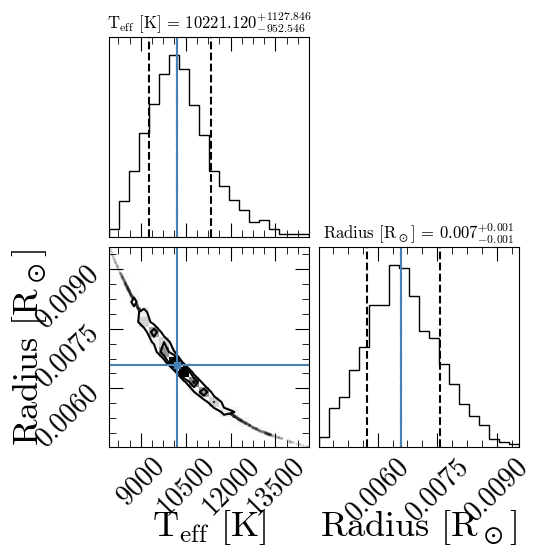

In [20]:
from corecomposition import interpolator
import corner

print(bands[0:3])
gaia_model = interpolator.WarwickDAInterpolator(bands[0:3])
# run the MCMC fit using one of the interpolators
gaia_engine = interpolator.MCMCEngine(gaia_model)
gaia_flat_chain = gaia_engine.run_mcmc(photomet[0:3], e_photomet[0:3], distance, initial_guess)

labels = [r'$T_{eff}$ $[K]$', r'Radius $[R_\odot]$']
best_est = np.zeros((len(labels)))
unc = []

for i in range(len(labels)):
    mcmc = np.percentile(gaia_flat_chain[:, i],[16,50,84])
    best_est[i] = mcmc[1]
    unc.append(np.diff(mcmc))
unc = np.array(unc)

emcee_plot = corner.corner(gaia_flat_chain, labels=labels, truths = best_est, quantiles = [0.16, 0.5, 0.84], show_titles = True, 
                           title_fmt = '.3f', title_kwargs={"fontsize": 12})

plt.show()

(0.0, 1e-16)

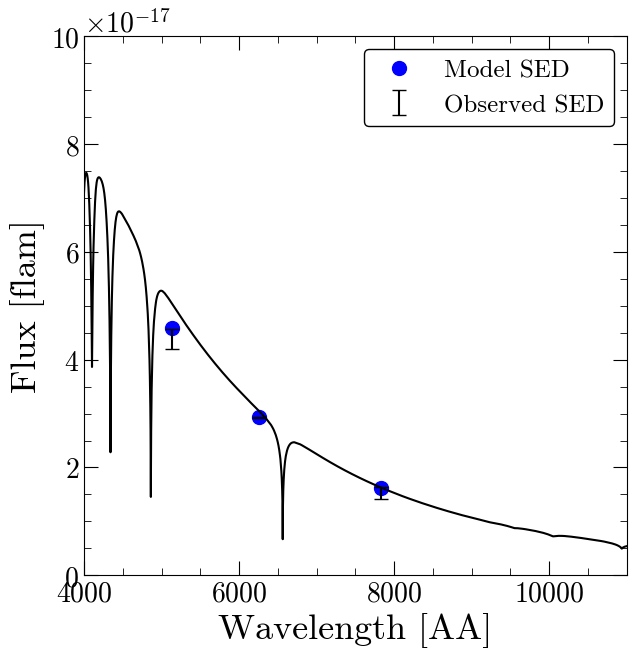

In [21]:
import pyphot
lib = pyphot.get_library()

model_flux = gaia_engine.get_model_flux(best_est, distance = distance)
flux, e_flux = gaia_engine.mag_to_flux(photomet[0:3], e_photomet[0:3])
wave = [lib[band].lpivot.to('angstrom').value for band in gaia_engine.bands]

plt.errorbar(wave, flux, yerr = e_flux, linestyle = 'none', marker = 'None', color = 'k',
                    capsize = 5, label = 'Observed SED', zorder=100)
plt.plot(wave, model_flux, 'bo', markersize = 10, label = 'Model SED')
plt.plot(base_wavl, build_spec(best_est, distance), c='k')
plt.xlabel(r'Wavelength [AA]')
plt.ylabel(r'Flux [flam]')
plt.legend()
plt.xlim(4000, 11000)
plt.ylim(0, 1e-16)

['PS1_g' 'PS1_r' 'PS1_i' 'PS1_z' 'PS1_y']
Auto-Correlation Time = 39.85937648069086, additional steps = -428


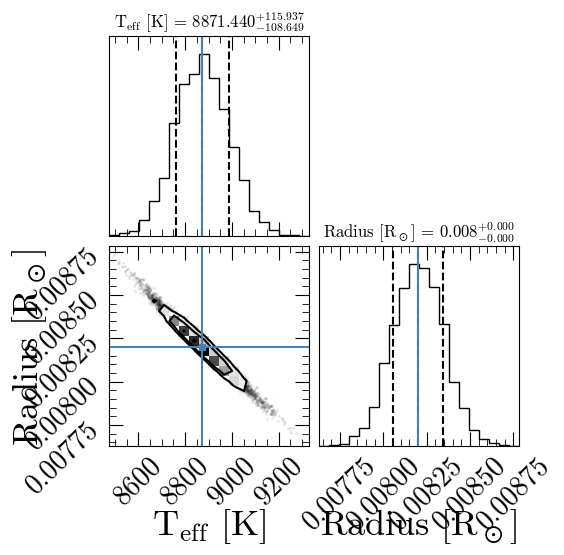

In [22]:
print(bands[3:])

#panstarrs_model = interpolator.LaPlataUltramassive(bands[3:], core = 'CO', layer = 'Hrich')
panstarrs_model = interpolator.WarwickDAInterpolator(bands[3:])
# run the MCMC fit using one of the interpolators
panstarrs_engine = interpolator.MCMCEngine(panstarrs_model)
panstarrs_flat_chain = panstarrs_engine.run_mcmc(photomet[3:], e_photomet[3:], distance, initial_guess)

labels = [r'$T_{eff}$ $[K]$', r'Radius $[R_\odot]$']
best_est = np.zeros((len(labels)))
unc = []

for i in range(len(labels)):
    mcmc = np.percentile(panstarrs_flat_chain[:, i],[16,50,84])
    best_est[i] = mcmc[1]
    unc.append(np.diff(mcmc))
unc = np.array(unc)

emcee_plot = corner.corner(panstarrs_flat_chain, labels=labels, truths = best_est, quantiles = [0.16, 0.5, 0.84], show_titles = True, 
                           title_fmt = '.3f', title_kwargs={"fontsize": 12})

In [23]:
bands

array(['Gaia_G', 'Gaia_BP', 'Gaia_RP', 'PS1_g', 'PS1_r', 'PS1_i', 'PS1_z',
       'PS1_y'], dtype='<U7')

(4000.0, 11000.0)

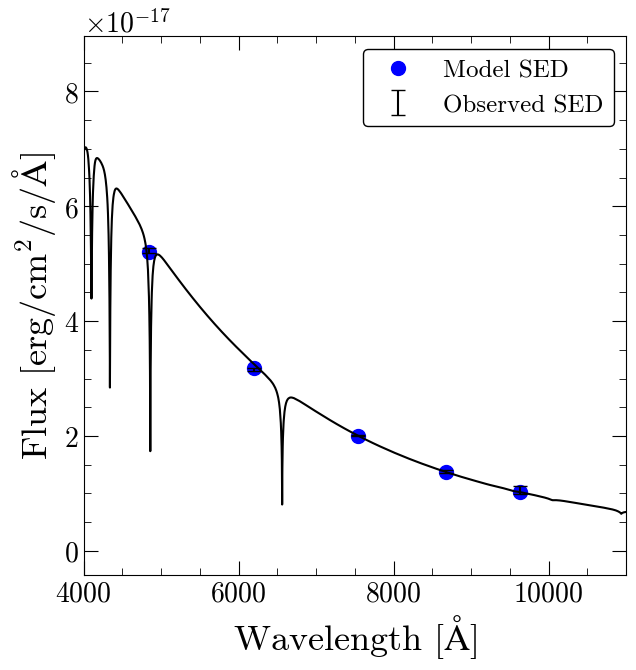

In [24]:
model_flux = panstarrs_engine.get_model_flux(best_est, distance = distance)
flux, e_flux = panstarrs_engine.mag_to_flux(photomet[3:], e_photomet[3:])
wave = [lib[band].lpivot.to('angstrom').value for band in panstarrs_engine.bands]

plt.errorbar(wave, flux, yerr = e_flux, linestyle = 'none', marker = 'None', color = 'k',
                    capsize = 5, label = 'Observed SED', zorder=100)
plt.plot(wave, model_flux, 'bo', markersize = 10, label = 'Model SED')
plt.plot(base_wavl, build_spec(best_est, distance), c='k')
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel(r'Flux [erg/cm$^2$/s/$\AA$]')
plt.legend()
plt.xlim(4000, 11000)

['Gaia_G' 'Gaia_BP' 'Gaia_RP' 'PS1_g' 'PS1_r' 'PS1_i' 'PS1_z' 'PS1_y']
Auto-Correlation Time = 40.606186351621744, additional steps = -389


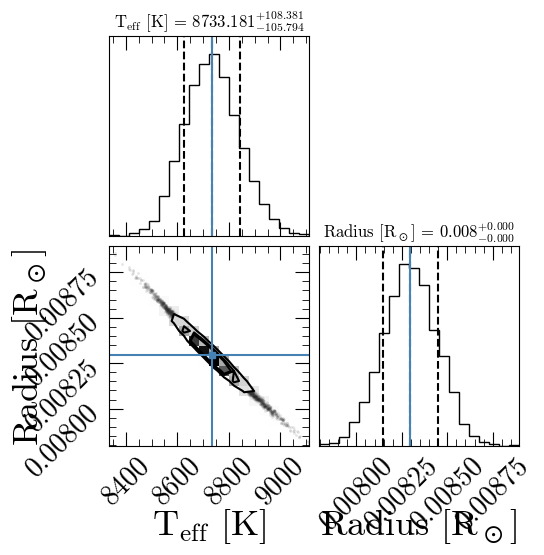

In [25]:
print(bands)
co_hrich_model = interpolator.WarwickDAInterpolator(bands)
# run the MCMC fit using one of the interpolators
engine = interpolator.MCMCEngine(co_hrich_model)
flat_chain = engine.run_mcmc(photomet, e_photomet, distance, initial_guess)

labels = [r'$T_{eff}$ $[K]$', r'Radius $[R_\odot]$']
best_est = np.zeros((len(labels)))
unc = []

for i in range(len(labels)):
    mcmc = np.percentile(flat_chain[:, i],[16,50,84])
    best_est[i] = mcmc[1]
    unc.append(np.diff(mcmc))
unc = np.array(unc)

emcee_plot = corner.corner(flat_chain, labels=labels, truths = best_est, quantiles = [0.16, 0.5, 0.84], show_titles = True, 
                           title_fmt = '.3f', title_kwargs={"fontsize": 12})

<>:10: SyntaxWarning: invalid escape sequence '\o'
<>:10: SyntaxWarning: invalid escape sequence '\o'
<>:10: SyntaxWarning: invalid escape sequence '\o'
<>:10: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_21153/1250653165.py:10: SyntaxWarning: invalid escape sequence '\o'
  capsize = 5, label = f'Observed SED\nInterp R = {catalog[gold]['cmd_radius'][i]:2.3f} $R_\odot$\nMCMC R = {best_est[1]:2.3f} $R_\odot$', zorder=100)
/tmp/ipykernel_21153/1250653165.py:10: SyntaxWarning: invalid escape sequence '\o'
  capsize = 5, label = f'Observed SED\nInterp R = {catalog[gold]['cmd_radius'][i]:2.3f} $R_\odot$\nMCMC R = {best_est[1]:2.3f} $R_\odot$', zorder=100)


(4000.0, 11000.0)

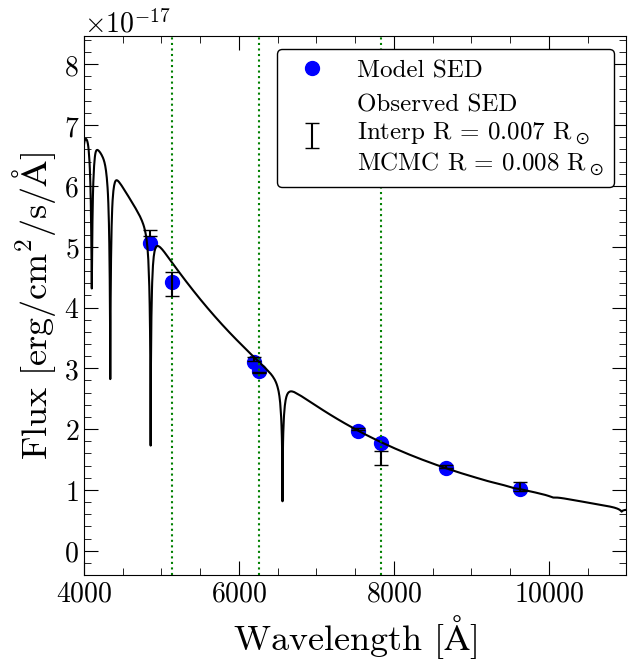

In [26]:
first_est = [9362, 0.009]

model_flux_best = engine.get_model_flux(best_est, distance = distance)
#model_flux_first = engine.get_model_flux(first_est, distance = distance)

flux, e_flux = engine.mag_to_flux(photomet, e_photomet)
wave = [lib[band].lpivot.to('angstrom').value for band in engine.bands]

plt.errorbar(wave, flux, yerr = e_flux, linestyle = 'none', marker = 'None', color = 'k',
                    capsize = 5, label = f'Observed SED\nInterp R = {catalog[gold]['cmd_radius'][i]:2.3f} $R_\odot$\nMCMC R = {best_est[1]:2.3f} $R_\odot$', zorder=100)
plt.plot(wave, model_flux_best, 'bo', markersize = 10, label = 'Model SED')
plt.plot(base_wavl, build_spec(best_est, distance), c='k')

for i in range(3):
    plt.axvline(wave[i], c = 'green', ls = ':')

plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel(r'Flux [erg/cm$^2$/s/$\AA$]')
plt.legend()
plt.xlim(4000, 11000)

In [27]:
source_ids

2153552814748001792

In [28]:
bronze[bronze['wd_source_id'] == source_ids][['ms_source_id', 'wd_ra', 'wd_dec']]

ms_source_id,wd_ra,wd_dec
int64,float64,float64
2153552647245580544,284.65870302124665,57.78819239158009


In [29]:
catalog[gold][['wd_source_id', 'cmd_radius', 'radius_med']]

wd_source_id,cmd_radius,radius_med
int64,float64,float64
2153552814748001792,0.0067775427053977004,0.00917106618684483
3249027001465705088,0.007198684270318171,0.007948928631084068
4248619071266347648,0.007001884607420573,0.008370611192363032
4248619071266347648,0.007001884607420573,0.008370611192363032
4248619071266347648,0.007001884607420573,0.008370611192363032
4248619071266347648,0.007001884607420573,0.008370611192363032


In [30]:
elbadry = Table.read('../data/raw/elbadry.csv')



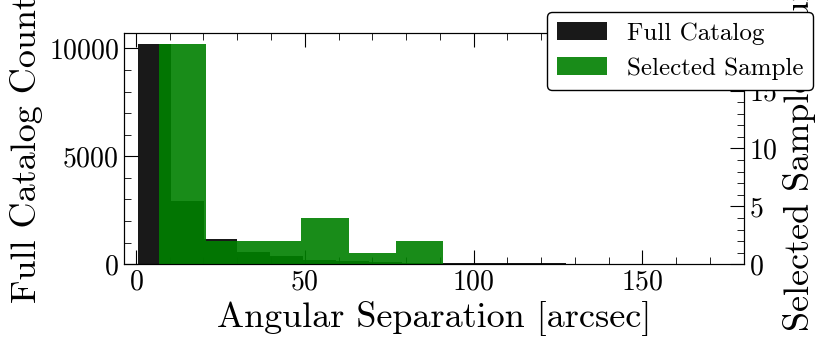

In [31]:
fig, ax1 = plt.subplots(figsize=(8,3))
ax1.set_xlim(-0.001*3600, 0.05*3600)
ax1.set_xlabel(r'Angular Separation [arcsec]')
ax2 = ax1.twinx()

ax2.hist(bronze['pairdistance']*3600, zorder = 1, color = 'green', alpha = 0.9, label = 'Selected Sample')
ax2.set_ylabel('Selected Sample Count')
ax1.hist(elbadry['pairdistance']*3600, bins = 100, alpha = 0.9, label = 'Full Catalog', color = 'k', zorder = 0);
ax1.set_ylabel('Full Catalog Count')

fig.legend()
